# Workshop -- Machine learning in life sciences
### What is it, when should it be used and how to avoid common pitfalls

**Author:** Benjamin Goudey, Research Fellow in Computing and Information Systems at The University of Melbourne

# Introduction
Welcome to the workshop! This notebook accompanies the workshop *Applying machine learning in life sciences: what does it mean and how to avoid common traps.*

The notebook focuses on the problem of predicting diabetes from a few clinical and blood measurements, as well as several "noise" variables.

The notebook is split into into four sections. 

0. Welcome and setup
1. Exploring the data and fitting a model and measuring performance
2. Pitfall 1: Evaluation frameworks and generalisation
3.  Pitfall 2: Selecting features and model parameters

There will be a number of models, measures and algorithms that will be used and will be briefly explained in the accompanying tutorial but will not be covered in detail. The skikit-learn documentation will be valuable here (https://scikit-learn.org/stable/modules/classes.html)

The notebook assumes familiarity with python, and a passing familiarity with the pandas, matplotlib/seaborn and numpy/scipy packages. Comments have been placed around the code and the expectation is you should be able to follow along rather than write this code from scratch.


# 0 Notebook Setup 


## 0.1 Install and load required packages

## YOU WILL PROBABLY NEED TO RUN THIS CELL TWICE!
It installs a recent version of pandas-profiling, a tool for summarising the content of a pandas data frame. When the install occurs, a little reset button will appear. Press this and re-run the cell to load all packages into your environment, 

In [9]:
!pip install pandas-profiling==3.0.0
# Load in everything we need
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal as mvn

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, GridSearchCV
from sklearn import datasets
from sklearn import metrics
from sklearn import feature_selection
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import graphviz 

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas-profiling - generates an interactive report
from pandas_profiling import ProfileReport


You should consider upgrading via the '/Users/bgoudey/Research/Slides/BioInfoSummer2021_ML/env/bin/python3.9 -m pip install --upgrade pip' command.


## 0.2 Loading helper function

In [10]:
#

# Add some random noise to a given data.frame
def append_noise(df, n_noise=20):
    noise_measures = np.random.rand(df.shape[0],n_noise)
    noise_measures = StandardScaler().fit(noise_measures).transform(noise_measures)
    noise_names = ["noise_{}".format(i) for i in range(n_noise)]
    noise_df = pd.DataFrame(data=noise_measures,columns=noise_names)
    return(pd.concat([df,noise_df], axis=1))

# Change the target to be binary
def binarize_y(y):     
    return(1*(y>100))

# Rename a number of columns to make them more describptive
def tidy_diabetes_names(X):     
    # We rename the variables to be more descriptive
    X.rename({'s1': 'tc', 
              's2': 'ldl', 
              's3': 'hdl',
              's4': 'tch',
              's5': 'ltg',
              's6': 'glu',}
             , axis=1, inplace=True)
    return(X)


#
#
# Generate a new dataset based on the existing diabetes dataset
def generate_novel_data(n_samples=1000, n_noise=20):

    # Reload the diabetes dataset to retrieve the continuous progression score    
    X,y=datasets.load_diabetes(as_frame=True, return_X_y=True)
    
    # We rename the variables to be more descriptive
    X = tidy_diabetes_names(X)

    # Combine X and y into a single data.frame
    X_y = X.assign(y = y)
    
    # Based on existing data means and covariance, generate some new data 
    # (assumes mutlivariate normal, unlikely to be true but good enough)
    # Then turn into a data.frame
    sim_dat = mvn.rvs(mean = X_y.mean(), cov=X_y.cov(), size = n_samples)
    sim_X_y = pd.DataFrame(data = sim_dat, columns = X_y.columns)

    # Split back in to X and y
    sim_y = binarize_y(sim_X_y['y'])
    sim_X = sim_X_y.drop(columns=['y'])
    
    #If we've specified, add some number of randomly generated features   
    if n_noise>0:
        sim_X=append_noise(sim_X, n_noise)
    
    return(sim_X, sim_y)
    
    
#
# Load in the diabetes dataset that comes with sklearn. 
# Then tidy names, binaryise the progression variable and add some noise (if specified)
def load_diabetes_data(n_noise=20):
    # Load in the data as a data.frame, split into X (features) and y (target) 
    X,y=datasets.load_diabetes(as_frame=True, return_X_y=True)
    
    # The defaul names are a bit strange so we clean then up
    X = tidy_diabetes_names(X)
    
    # Target variable is a quantitative measure of disease progression one year after baseline
    # that we dichotimise (turn into two groups) to simplify some analysis. 
    y = binarize_y(y)

    #If we've specified, add some number of randomly generated features
    if n_noise>0:
        X=append_noise(X, n_noise)
    
    X_sim, y_sim = generate_novel_data(n_samples=1000, n_noise=n_noise)
    
    return (X, y, X_sim, y_sim)

# Plot a ROC curve with a label
def plot_roc(y, yp, label="", ax=None):
    fpr, tpr, thresh = metrics.roc_curve(y, yp)
    auc = metrics.roc_auc_score(y, yp)
    if ax:
        ax.plot(fpr,tpr,label="{} AUC={:.2f}".format(label, auc))
    else:
        plt.plot(fpr,tpr,label="{} AUC={:.2f}".format(label, auc))


# Session 1: Exploring the data and fitting a basic model

Here, we will explore a given dataset related to diabetes and fit a basic model using the scikit-learn package.

In particular, we aim to
 - understand the dataset, its variables and their relationship. 
 - introduce the pandas-profiling and scikit-learn packages. 
 - demonstrate how to fit a model using sklearn and look at the outputs. 

## Background: Dataset

We will be making use of a real dataset of 442 diabetes patients as well as a simulated dataset derived from this data. This is relatively small in the machine learning space but is common (or even large) for many clinical/bioinformatics analyses. 

10 attributes have been measured, with variable names and descriptions given below:
- *age*: age in years
- *sex*: biological sex of the participant
- *bmi*: body mass index
- *bp*: average blood pressure
- *tc*: total serum cholesterol
- *ldl*: low-density lipoproteins
- *hdl*: high-density lipoproteins
- *tch*: total cholesterol / HDL
- *ltg*: possibly log of serum triglycerides level
- *glu*: blood sugar level

Here, we predict a binary target indicating progression of diabetes after one year or not (1 or 0). This is derived from "a quantitative measure of disease progression one year after baseline" (Efron et al. (2004)) though it is unclear exactly what this measurement is. I've threshold this value at 100. 


We derive a simulated dataset from the original dataset which we treat as an external replication cohort. By default there are 1000 samples in this simulated data. 

### Analysis aim
The analysis goals from this dataset are typical of a predictive task in this area: 
>Two hopes were evident [from the data], that the model would produce accurate baseline predictions of response for future patients and that the form of the model would suggest which covariates were important factors in disease progression.

I'm going to assume a more specific question **"do blood serum markers help predict diabetes progression beyond age, sex, bmi and blood glucose?"**. Now we have a specific baseline we can evaluate against. 

Further information is available at https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset and data is taken from the original paper https://tibshirani.su.domains/ftp/lars.pdf.


 

## 1.1 Load in the data
We will load in a cleaned-up version of the dataset (using the *load_diabetes_data()* function).

In [11]:
# This cell creates of the dataframe that has been entered. 
X, y, X_ext, y_ext = load_diabetes_data(n_noise=40)

print(X)

          age       sex       bmi        bp        tc       ldl       hdl  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017282 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081414  0.083740  0.027809  0.173816   

          tch       ltg       glu  ...  noise_30  noise_31  noise_32  \
0  

## 1.2 Data exploration
We'll begin by exploring the data that is available. While we have a description of the fields, understanding the relationships between individual features and their relationship with the outcome of interest is informative for helping to understand downstream. 

Rather than try to generate a bunch of plots manually, we can make use of a package called *pandas-profiling*, which provides a bunch of handy plots. *This will take a minute or two to run*. After that a small report below will be generated that provides an overview of the different features and their relationships. 

**Examine the following:**

1. What are the different types of features - which are numerical? which are categorical? are any unclear?
2. Which features are correlated with each other? How strong are these?
3. Is there anything unexpected about the data?
4. Is there any missing data?
5. What does the target variable look like? What is its distribution? Are there any obvious relationships?



In [12]:
# Ignore the noise features for this exploration
X_y = X.iloc[:, 0:11].assign(y = y)
profile = ProfileReport(X_y, 
                       correlations={
        "pearson": {"calculate": False},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": False},
    })

#profile.to_widgets()
# If you've installed pandas-profiling 3.1.0, you may need to replace the previous line, with the comment below. 
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]


KeyboardInterrupt: 

## 1.3 Fitting a model to the data

Lets fit a simple logistic regression to the data and look at how well it makes predictions on the data. The code below will fit a simple logistic regression , using only a single predictor (bmi), to allow for simple plots of the fit, and then using all available features. 

We begin by plotting the data, the model fit and some classic summary statistics. 

*Questions*:
 - Which features are the most predictive?
 - How much improvement to you get if you combined features compared to a model based on individual features?
 - Try regenerating the dataset with more or less noise. What happens to prediction accuracy as you add more noisy variables?
 


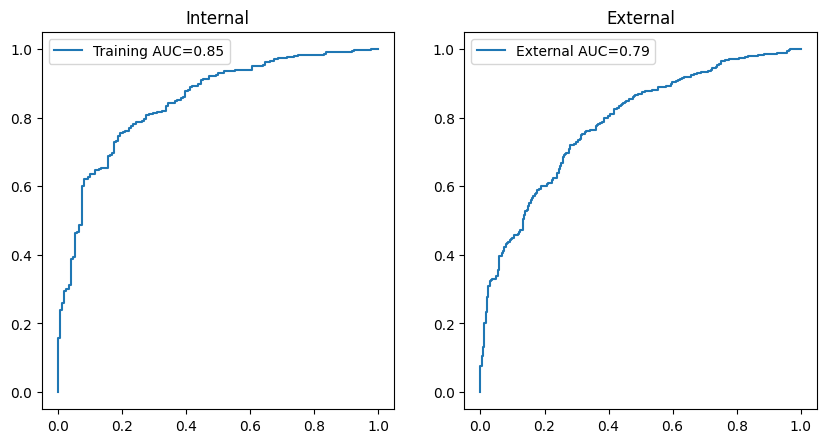

In [ ]:

# If you feel like generating a new dataset, uncomment this line. 
X, y, X_ext, y_ext = load_diabetes_data(n_noise=20)

# The features used to construct the model
# Change these and see how the results change
# This option would include all features
features= X.columns

# We can also look at individual features
#features="bmi"
#features="age"
#features="noise_1"

# This set will include 4 features
#features=["age", "sex", "bmi", "glu"]


# sklearn models expect a 2D array. However, when only a single column is selected in pandas, it is a
# 1D array. This conditional checks for when our input is a single column and turns it into a 2D array for sklearn.  
if type(features)==str:
    X_train    = X.loc[:, features].values.reshape(-1,1)
    X_eval = X_ext.loc[:, features].values.reshape(-1,1)
else:
    X_train    = X.loc[:, features]
    X_eval = X_ext.loc[:, features]
        
#Construct a classifier
clf = LogisticRegression(penalty='none', solver="saga", tol=0.01).fit(X_train, y)

# Get predicted labels from the classifier. Here, the 'predict_proba' function returns probabilities of the labels (e.g 75% of belonging to class 1)
y_pred = clf.predict_proba(X_train)[:,1]

y_ext_pred = clf.predict_proba(X_eval)[:,1]


fig, ax=plt.subplots(nrows=1,ncols=2, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')

# PLot a ROC curve and show the area under the curve. 
plot_roc(y, y_pred, ax=ax[0], label="Training")
plot_roc(y_ext, y_ext_pred, ax=ax[1], label="External")
ax[0].legend(loc=0)
ax[0].title.set_text('Internal')
ax[1].legend(loc=0)
ax[1].title.set_text('External')


## 1.4 Examine top features
Logistic regression provides an interpretable model. To see which features are most important, we can look at the coefficients of each variable. Larger absolute values implies more impact in the predictions. 


**Examine the following:**

1. Do any noise variables make it into the top 10?
2. What if you generate lots of noise variables (>1000)


In [ ]:
coefs_df = pd.DataFrame.from_dict({'feature':features, 'coef':clf.coef_[0]})
coefs_df.sort_values(by="coef", key=np.abs, ascending=False).iloc[0:15, :]

AttributeError: 'DecisionTreeClassifier' object has no attribute 'coef_'

<hr style="border:2px solid gray"> </hr>

# Session 2: models and metrics in sklearn

In the previous example, we fit a logistic regression model to the given dataset and examine its performance using AUC. However, in many studies where we are looking to create a predictive model, we will be interested in creating multiple models based on different underlying algorithms and possibly evaluating them based on different criteria. Here, we demonstrate how these different models and metrics can be called and provide a few examples with our diabetes dataset as to the information you get.      

# 2.1 Exploring different models
The sklearn has quite a standardised interface for fitting and applying different models. In particular clf.fit(X, y) and clf.predict_proba(X) can be used to fit a model and then extract the probabilities of the predicted classes. Comparable functions exist when looking at continuous or multi-label outcomes. 

These standardised interfaces allow us to easily explore the impact of different classifiers for a problem. UNderstanding the different assumptions and methods is beyond this workshop. However, we can explore how this is done and talk through the impact of diffent classifiers. 




**Examine the following:**

1. Do any noise variables make it into the top 10?
2. What if you generate lots of noise variables (>1000)



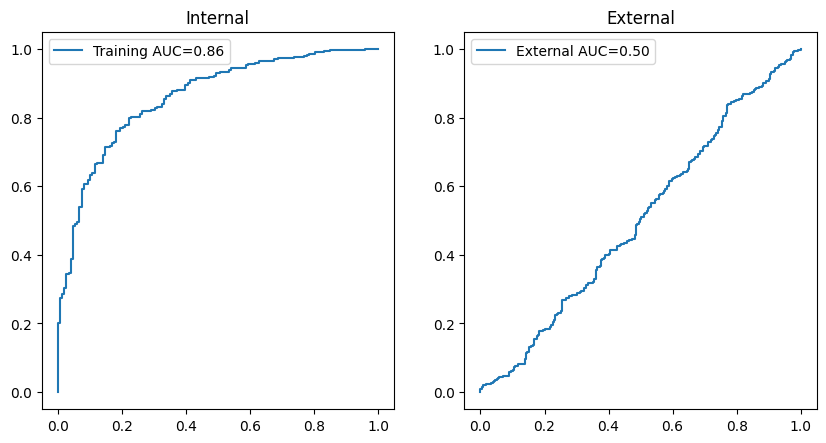

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

X, y, X_ext, y_ext = load_diabetes_data(n_noise=20)



#clf=LogisticRegression(penalty='none', solver="saga", tol=0.01)
#clf=LogisticRegression(penalty='l2',C=10, tol=0.01)
#clf=RandomForestClassifier(max_depth=1, random_state=0)
#clf=DecisionTreeClassifier(max_depth=None, random_state=0)


clf.fit(X_train, y)

# Get predicted labels from the classifier. Here, the 'predict_proba' function returns probabilities of the labels (e.g 75% of belonging to class 1)
y_pred = clf.predict_proba(X_train)[:,1]
y_ext_pred = clf.predict_proba(X_eval)[:,1]


fig, ax=plt.subplots(nrows=1,ncols=2, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')

# PLot a ROC curve and show the area under the curve. 
plot_roc(y, y_pred, ax=ax[0], label="Training")
plot_roc(y_ext, y_ext_pred, ax=ax[1], label="External")
ax[0].legend(loc=0)
ax[0].title.set_text('Internal')
ax[1].legend(loc=0)
ax[1].title.set_text('External')


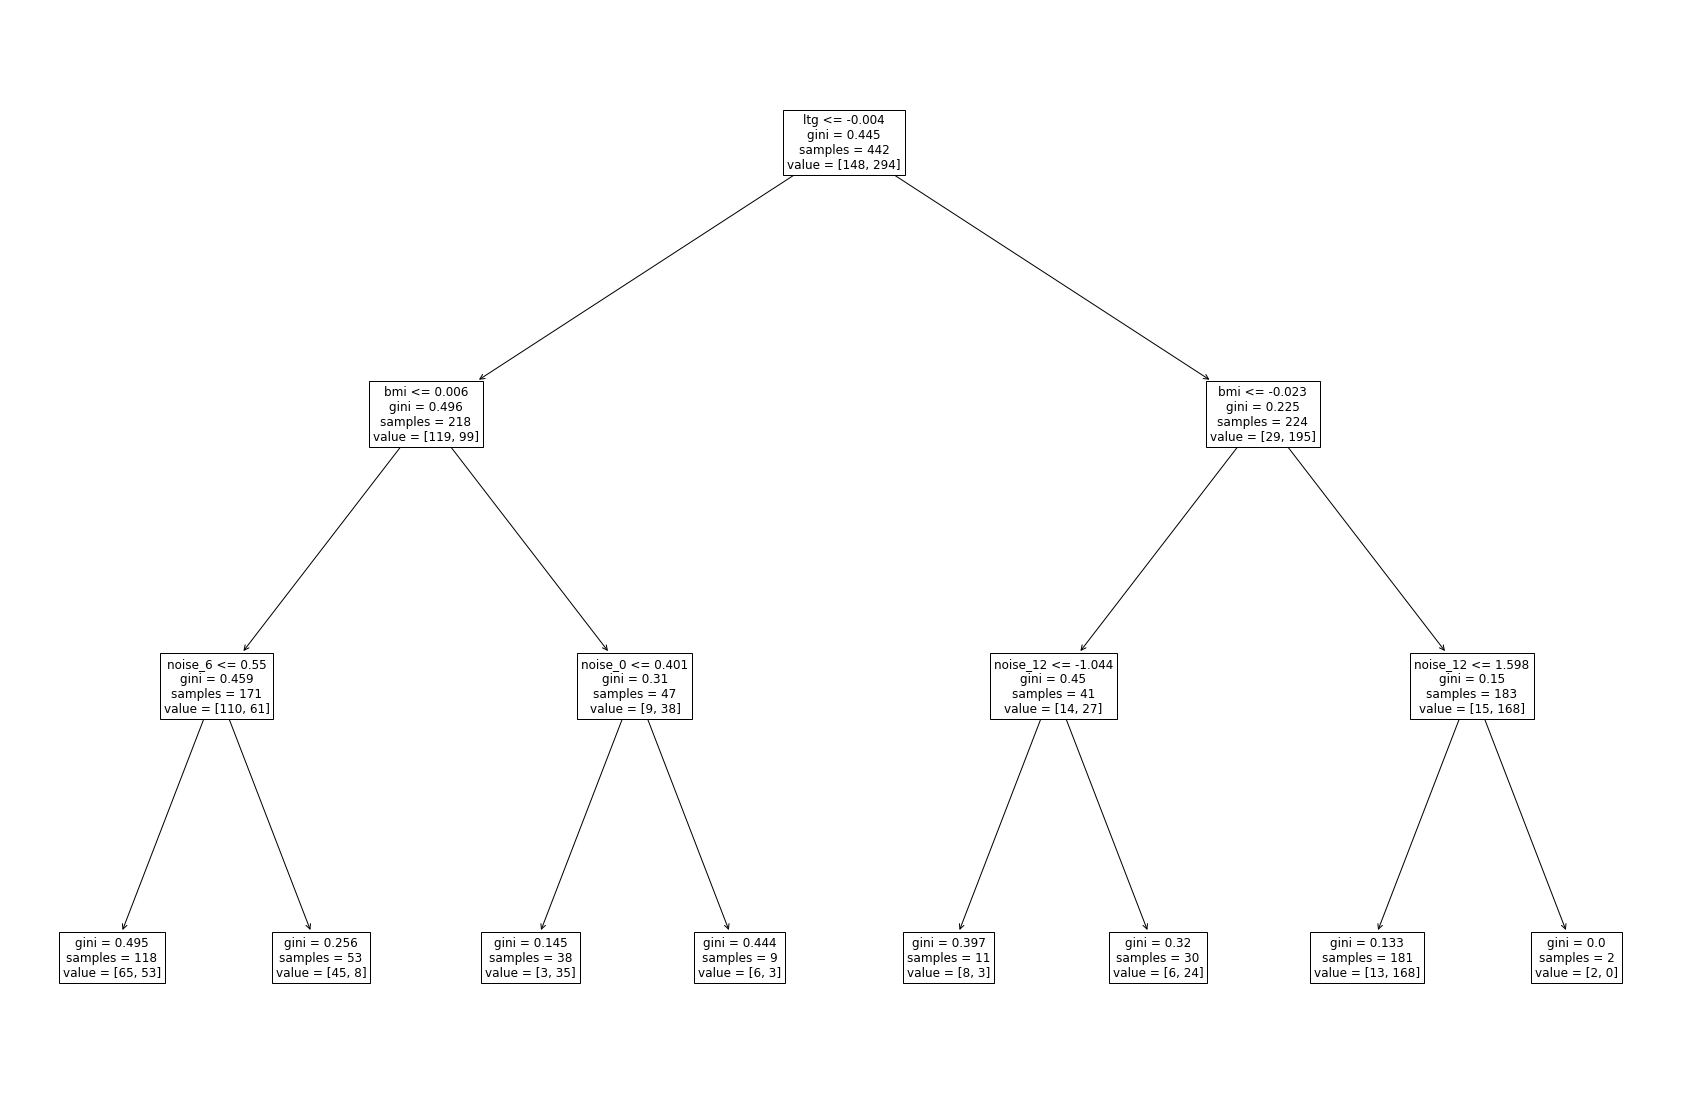

In [36]:
from sklearn import tree

#Fit a decision tree. 
clf=DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y)

#These parameters control the size of the resulting figure. If your model is too deep, you may need to make these values larger
plt.figure(figsize=(30,20))  
tree.plot_tree(clf, feature_names = X_train.columns, fontsize=12)

#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data, )
plt.show()


# 2.3 Exploring different metrics
We can also change the way that we evaluate model performance, again through the standardised interface provided by scikit-learn

A list of possible options are provided can be see at  
https://scikit-learn.org/0.16/modules/model_evaluation.html


**Examine the following:**

1. Do different metrics ever change the ranking of which methods are best? 
2. How do results compare on the internal and external predictions? Are they the same? Do they dramatically differ? 
3. What happens when you adjust the amount of noise variables in the dataset?

In [61]:
# If you feel like generating a new dataset, uncomment this line. 
X, y, X_ext, y_ext = load_diabetes_data(n_noise=100)

#Create a dictionary of multiple classifiers
clfs = {
    'Ridge':LogisticRegression(penalty='l2',C=10, tol=0.01), 
    'LogisticReg':LogisticRegression(penalty='none', solver="saga", tol=0.01), 
    'Lasso':LogisticRegression(penalty='l1', C=100, solver="saga", tol=0.01), 
    'RandomForest':RandomForestClassifier(max_depth=20, random_state=0), 
    'DecisionTree':DecisionTreeClassifier(max_depth=3, random_state=0)
}
metrics_dict = {
    'Accuracy':metrics.accuracy_score,
    'BalAccuracy':metrics.balanced_accuracy_score,
    'AUC':metrics.roc_auc_score,
    'LogLoss':metrics.log_loss,
    'PPV':metrics.precision_score,
    'NPV':metrics.precision_score,
}

#Helper function to return classifier name
def get_clf_name(estimator):
    return(estimator.__class__.__name__)

scores = {}
for clf_name,clf in clfs.items():
    scores[clf_name] = {}
    clf.fit(X, y)
    for metric_name, metric in metrics_dict.items():
        scores[clf_name][metric_name + '_Internal']=metric(y, clf.predict(X))
        scores[clf_name][metric_name + '_External']=metric(y_ext, clf.predict(X_ext))

pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame(scores)


#clfs_res=[]
#print("{} total classifiers: ".format(len(clfs.items())), end="")
#for i, (clf_name, clf) in enumerate(clfs.items()):

,Ridge,LogisticReg,Lasso,RandomForest,DecisionTree
Accuracy_Internal,0.85,0.80,0.80,1.00,0.82
Accuracy_External,0.71,0.67,0.67,0.82,0.73
BalAccuracy_Internal,0.81,0.75,0.75,1.00,0.82
BalAccuracy_External,0.63,0.56,0.56,0.70,0.70
AUC_Internal,0.81,0.75,0.75,1.00,0.82
AUC_External,0.63,0.56,0.56,0.70,0.70
LogLoss_Internal,5.31,6.80,6.80,0.00,6.25
LogLoss_External,10.12,11.47,11.47,6.32,9.26
PPV_Internal,0.85,0.81,0.81,1.00,0.89
PPV_External,0.81,0.78,0.78,0.83,0.86


<hr style="border:2px solid gray"> </hr>

# Session 3: Train/test and cross-validation frameworks

In the previous example, we built model on entire dataset and evaluated its performance on the same data. Here, we will explore some alternative frameworks for doing this and will evaluate how model performance changes. We'll also start to explore different models and how key parameters can be altered to change prediction performance. 

## 3.1 Training and Test split

The following code examines training and testing a model on a single dataset and compares its performance to an external dataset in 3 scenarios:
 - Training on the entire dataset. Test on the same entire dataset. 
 - Training on a proportion (default 80%). Test on the same proportion. 
 - Training on a proportion (default 80%). Test on the remaining proportion. 
 
**Questions:**
1. Run this cell a few times. Which accuracies change? Why?
2. Which evaluation scenario is closest to the external data performance?
2. What is the best performance you can get by default? What is the worst performance you observe?
3. What happens to test performance as you add more noise variables?
4. Try changing parameters ('C' for the l2 penalized logistic regression, or max_depth for Random Forest)

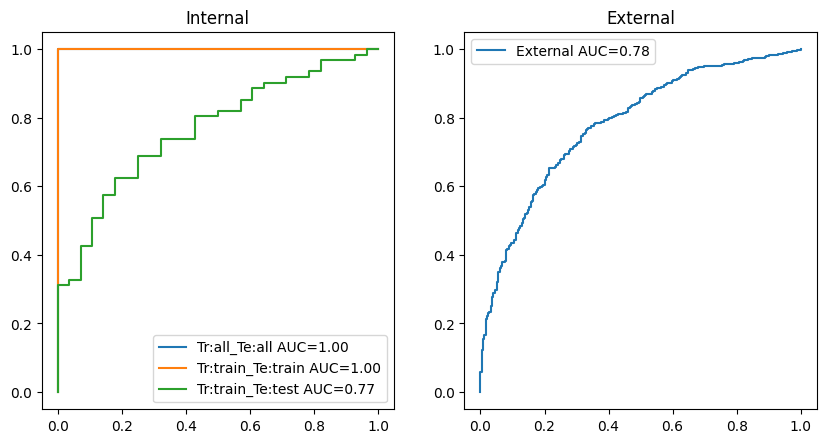

In [13]:
# If you feel like generating a new dataset, uncomment this line. 
#X, y, X_ext, y_ext = load_diabetes_data(n_noise=40)

#Select a model to construct
#clf=LogisticRegression(penalty='none', solver="saga", tol=0.01)
#clf=LogisticRegression(penalty='l2',C=10, tol=0.01)
clf=RandomForestClassifier(max_depth=10, random_state=0)

# Propotion of data
test_prop = 0.2

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop)

scenarios = {
                "Tr:all_Te:all":    {"train":{'X':X,'y':y}, "test":{'X':X,'y':y}}, 
                "Tr:train_Te:train":  {"train":{'X':X_train,'y':y_train}, "test":{'X':X_train,'y':y_train}}, 
                "Tr:train_Te:test":   {"train":{'X':X_train,'y':y_train}, "test":{'X':X_test,'y':y_test}}
            }

fig, ax=plt.subplots(nrows=1,ncols=2, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')


# Fit the model on the internal data and plot the results
for name, sc in scenarios.items():
    clf.fit(sc['train']['X'], sc['train']['y'])
    
    yp=clf.predict_proba(sc['test']['X'])[:,1]    
    plot_roc(sc['test']['y'], yp, name, ax=ax[0])
   
# Fit the model on the external data and plot the results
clf.fit(X, y)
yp_ext=clf.predict_proba(X_ext)[:,1]
plot_roc(y_ext, yp_ext, "External", ax=ax[1])
    
ax[0].legend(loc=0)
ax[0].title.set_text('Internal')
ax[1].legend(loc=0)
ax[1].title.set_text('External')

## 3.2 K-fold Cross-validation
Variability in the performance of different splits in the previous example motivates the use of K-fold cross validation. Here, we explore a few models and start to compare model performance.  

***Warning***: Be careful setting the values below. Setting the number of times to evaluate the classifiers too high and it will take too long to run for this workshop. 

**Questions:**
1. Run this cell a few times. What is the range of the scores that are observed?
2. Which model is the best? How do you determine this?
3. Play around with hyperparameters, what is the impact on model performance? Which models are sensitive to these choices?


4 total classifiers: 0123Done

<AxesSubplot:xlabel='clf', ylabel='auc'>

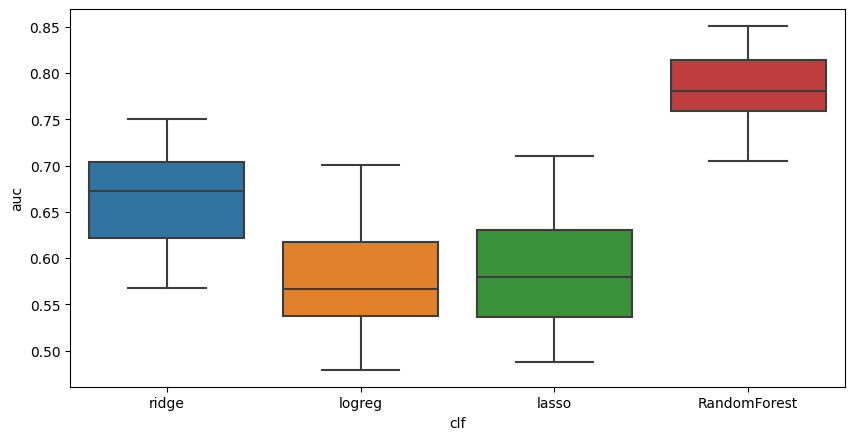

In [15]:
# If you feel like generating a new dataset, uncomment this line. 
X, y, X_ext, y_ext = load_diabetes_data(n_noise=100)

clfs = {
    'ridge':LogisticRegression(penalty='l2',C=10, tol=0.01), 
    'logreg':LogisticRegression(penalty='none', solver="saga", tol=0.01), 
    'lasso':LogisticRegression(penalty='l1', C=100, solver="saga", tol=0.01), 
    'RandomForest':RandomForestClassifier(max_depth=20, random_state=0), 
}

def get_clf_name(estimator):
    return(estimator.__class__.__name__)

# This constructs n_splits * n_repeats classifiers. If these values are large, 
# or if classifier is slow it may take a long time    
n_folds=5
n_reps=3
cv = RepeatedKFold(n_splits=n_folds,n_repeats=n_reps)

clfs_res=[]
print("{} total classifiers: ".format(len(clfs.items())), end="")
for i, (clf_name, clf) in enumerate(clfs.items()):
    print(i, end="")
    scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc")
    
    #Turn the results into a data frame and 
    clf_res=pd.DataFrame(data = scores, columns = ['auc']).assign(clf=clf_name)
    clfs_res.append(clf_res)
print("Done", end="")

clfs_res_merge = pd.concat(clfs_res)

fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
sns.boxplot(data=clfs_res_merge, y='auc', x="clf",ax=ax )

# Session 4. Overfitting via feature selection and model parameters


## 4.1 Feature discrimination over entire dataset
One naive way to remove noise is to look at the features one-by-one,  look at their ability to discriminate the dataset and only take the most useful into our model. This is flawed but is common in the literature. 

Lets take a look at the discriminatory ability of our features, here using an ANOVA, a common statistical test. We report the f-statistic (a measure of effect size) and p-value for each features. 

**Question:** 
1. How do measured and noise features compare?
2. What if we generate lots (n=10,000) noise features? How often can we distinguish noise and real signal?

In [16]:
# If you feel like generating a new dataset, uncomment this line. 
X, y, X_ext, y_ext = load_diabetes_data(n_noise=10)

# Look at which features are important over the entire dataset
f, p = feature_selection.f_classif(X, y)
feature_scores = pd.DataFrame.from_dict({"feature":X.columns, "f-stat":f, "p.val":p})
feature_scores.sort_values(by="p.val", key=np.abs, ascending=True).iloc[0:10, :]

,feature,f-stat,p.val
8,ltg,115.586523,4.279964e-24
2,bmi,90.156027,1.415061e-19
7,tch,64.081024,1.073645e-14
6,hdl,62.105617,2.580875e-14
3,bp,55.190683,5.735314e-13
9,glu,36.446028,3.338673e-09
4,tc,15.441600,9.879301e-05
5,ldl,13.971796,2.100505e-04
0,age,10.535308,1.260592e-03
15,noise_5,1.174173,2.791388e-01


## 4.2 Demonstrating potential overfitting when selecting features before CV
Given we've ranked the features in terms of their discrinatory ability, we could now select some top amount (based on p-value, f-statistic or a feeling for how many features we need). 

But such an approach uses all of the information, and hence means there is no unsed data left for an untouched test set. 

To explore this impact, the code below plots classifier performance starting with a single most discrinimatory feature and increasing to the top 32 features. We plot the model performance in training and testing. 

Additionally, we plot the performance of constructing a model on all samples and evaluating the external dataset to show where the ideal would be. 

**Questions**
1. What are the trends in the performance of the model on the training data as we increase features?
2. What are the trends in the performance of the model on the test data as we increase features?
3. Where is the ideal number of features for the external data?
4. How often does number of features to achieve the highest "test" performance correspond to the hihgest external performance?
5. What happens if you run this cell a few times? How do results differ? Why do they change?


<AxesSubplot:xlabel='n_feat', ylabel='auc'>

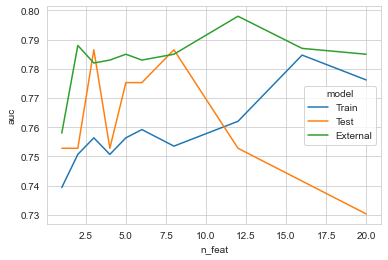

In [18]:
clf = LogisticRegression(penalty='none', tol=0.01, solver='saga')
#clf = RandomForestClassifier(max_depth=20, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop)

#Look at different numbers of features in the model. Remove any that are bigger than our current dataframe
n_feats = [1,2,3, 4,5, 6, 8,12,16,20, 24, 28, 32, 64, 128, 1000]
n_feats = filter(lambda x: x<=len(X_train.columns), n_feats)
aucs=[]
for i in n_feats:

    #This is a clever trick, where we make a pikeline that first searches 
    # for the 'k' best features and then applies a classifier  to the filtered data. 
    clf_selected = make_pipeline(SelectKBest(f_classif, k=i),clf)
    
    #Use this to conduct feature selection on the entire dataset
    clf_selected.fit(X, y)
    #Use this to conduct feature selection only on the training data
    #clf_selected.fit(X_train, y_train)
      
    aucs.append(pd.DataFrame.from_dict({
        "n_feat": [i,i],
        "model" : ["Train", "Test"],
        "auc" : [clf_selected.score(X_train, y_train), 
                   clf_selected.score(X_test, y_test)]
    }))
    
    clf_selected.fit(X, y)
    aucs.append(pd.DataFrame.from_dict({
        "n_feat": [i],
        "model" : ["External"],
        "auc" : [clf_selected.score(X_ext, y_ext)]
    }))
    
    
    
aucs_df=pd.concat(aucs, ignore_index=True)
sns.set_style("whitegrid")

sns.lineplot(data=aucs_df, x="n_feat", y="auc", hue="model")
f.set(xscale='log')

## 4.3 Nested cross-validation for feature selection and hyperparameter tuning

Rather than selecting the number of features to be included in a model (based on a random guess, or worse peeking at test results), we can instead conduct feature selection as part of cross validation. 

The code below runs two cross-validation loops (inner and outer), essentially running one loop on the training data (repeatededly breaking it into training and validation datasets) to understand how the number of features impacts performance. We then select the best number of features and evaluate the held-out testset. This is then repeated for the number of folds in the outer loop. 

While robust, the approach can be computationally expensive as we are building many models. 

**Warning** This code can be extremely slow

**Questions:**
1. Try generating a dataset with no noisy features and one with many? How much does performance vary?
2. How does performance vary if we change from a penalized regression to a random forest?


In [66]:
# Fit a regularise logistic regression
#clf = LogisticRegression(penalty='l2', solver="saga", tol=0.01)
clf = RandomForestClassifier(max_depth=20, random_state=0)

# Form a grid of parameters to look over
#param_grid = {"selectkbest__k": [1,2,3, 4,5, 6, 8,12,16,20, 24, 28, 32], "logisticregression__C": [0.01, 0.1, 1,5, 10, 50, 100]}
param_grid = {"selectkbest__k": [1,2,3, 4,5, 6, 8,12,16,20, 24, 28, 32], "randomforestclassifier__max_depth": [5, 20, 50, 100]}



model_to_tune = make_pipeline(SelectKBest(f_classif),clf)
    
test_score_not_nested = []
test_score_nested = []

n_rep = 3
n_split_outer=5
n_split_inner=3

for i in range(n_rep):
    print(i, end='')
    inner_cv = KFold(n_splits=n_split_inner, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=n_split_outer, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, scoring="roc_auc")
    model.fit(X, y)
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(model, X, y, cv=outer_cv, scoring="roc_auc")
    test_score_nested.append(test_score.mean())


all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=True)
plt.xlabel("AUC")
plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")

0

ValueError: Invalid parameter RandomForestClassifier for estimator Pipeline(steps=[('selectkbest', SelectKBest()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, random_state=0))]). Check the list of available parameters with `estimator.get_params().keys()`.

## Final task
Using the above code, can you implement a scheme to answer the question "do blood serum markers help predict diabetes progression beyond age, sex, bmi and blood glucose?".

Steps: 
 - Copy the code in the previous section
 - Add call to a model with a specified feature subset (as in section Cell 1.3)
 - Compare boxplots from these two models